## Imports

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import spacy
from nltk.corpus import stopwords

from lightgbm import LGBMClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline

import re

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [13]:
path_data = '../data/'

In [14]:
ls $path_data

cache/
jigsaw-joint-train.csv
jigsaw-multilingual-toxic-comment-classification.zip
jigsaw-toxic-comment-train.csv
jigsaw-toxic-comment-train-processed-seqlen128.csv
jigsaw-unintended-bias-train.csv
jigsaw-unintended-bias-train-processed-seqlen128.csv
sample_submission.csv
temp/
test.csv
test-processed-seqlen128.csv
validation.csv
validation-processed-seqlen128.csv


## Train data

In [15]:
# data from first competition. English comments from Wikipedia’s talk page edits.
train_wiki = pd.read_csv('../data/jigsaw-toxic-comment-train.csv')
# data from second competition. Civil Comments dataset with additional labels.
train_cc = pd.read_csv('../data/jigsaw-unintended-bias-train.csv')

In [16]:
train_wiki.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [17]:
train_wiki.shape

(223549, 8)

In [18]:
train_cc.head(3)

,id,comment_text,toxic,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,"This is so cool. It's like, 'would you want yo...",0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,Thank you!! This would make my life a lot less...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,This is such an urgent design problem; kudos t...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4


In [19]:
train_cc.shape

(1902194, 45)

In [20]:
train_cc.describe()

,id,toxic,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,parent_id,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
count,1.902194e+06,1.902194e+06,1.902194e+06,1.902194e+06,1.902194e+06,1.902194e+06,1.902194e+06,426707.000000,426707.000000,426707.000000,...,1.080354e+06,1.902194e+06,1.902194e+06,1.902194e+06,1.902194e+06,1.902194e+06,1.902194e+06,1.902194e+06,1.902194e+06,1.902194e+06
mean,3.912771e+06,1.030068e-01,4.585531e-03,1.388516e-02,2.259572e-02,8.117227e-02,9.298498e-03,0.011905,0.003362,0.001897,...,3.718802e+06,2.811915e+05,2.777982e-01,4.429990e-02,1.090688e-01,2.443550e+00,5.824227e-01,6.595598e-03,1.435714e+00,8.782232e+00
std,2.497349e+06,1.970813e-01,2.286902e-02,6.465998e-02,7.863447e-02,1.760987e-01,4.939469e-02,0.086914,0.051648,0.026259,...,2.450933e+06,1.040056e+05,1.054929e+00,2.457508e-01,4.563106e-01,4.720064e+00,1.861857e+00,4.525432e-02,1.774053e+01,4.338458e+01
min,5.984800e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,6.100600e+04,2.006000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,8.273542e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,7.942105e+05,1.600630e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
50%,5.282205e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,5.220304e+06,3.320280e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
75%,5.862735e+06,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00,0.000000,0.000000,0.000000,...,5.775190e+06,3.662350e+05,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00
max,7.194639e+06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,...,6.333965e+06,3.995440e+05,1.020000e+02,2.100000e+01,3.100000e+01,3.000000e+02,1.870000e+02,1.000000e+00,1.866000e+03,4.936000e+03


In [21]:
train_cc.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count'],
      dtype='object')

In [22]:
cols = ['comment_text' ,'toxic']
train = pd.concat([train_wiki[cols], train_cc[cols]])
train.head(3)

,comment_text,toxic
0,Explanation\nWhy the edits made under my usern...,0.0
1,D'aww! He matches this background colour I'm s...,0.0
2,"Hey man, I'm really not trying to edit war. It...",0.0


In [23]:
train['toxic'].value_counts()

0.000000    1535200
0.166667     138501
0.200000     113271
0.300000      59098
0.400000      52703
             ...   
0.967213          1
0.003707          1
0.093079          1
0.112500          1
0.034503          1
Name: toxic, Length: 3868, dtype: int64

In [24]:
train['target'] = (train['toxic'] > 0.5).astype(int)
train.target.value_counts()

0    1992133
1     133610
Name: target, dtype: int64

0    0.9043
1    0.0957
Name: toxic, dtype: float64


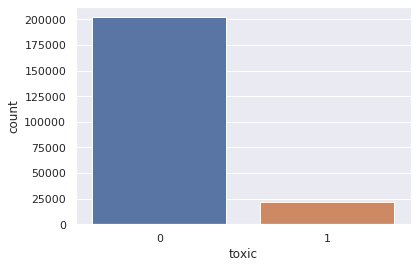

In [25]:
print(round(train_wiki['toxic'].value_counts(normalize=True),4))
sns.countplot(train_wiki.toxic);

In [26]:
train_wiki['comment_char_len'] = train_wiki['comment_text'].str.len()

In [27]:
%%time
nlp = spacy.load("en_core_web_sm")
train_wiki['comment_word_len'] = train_wiki['comment_text'].map(lambda x: len(nlp(x)))

CPU times: user 1h 59min 43s, sys: 5.11 s, total: 1h 59min 48s
Wall time: 1h 59min 57s


In [28]:
train_wiki.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_char_len,comment_word_len
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264,50
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112,28
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233,48
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622,133
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67,18


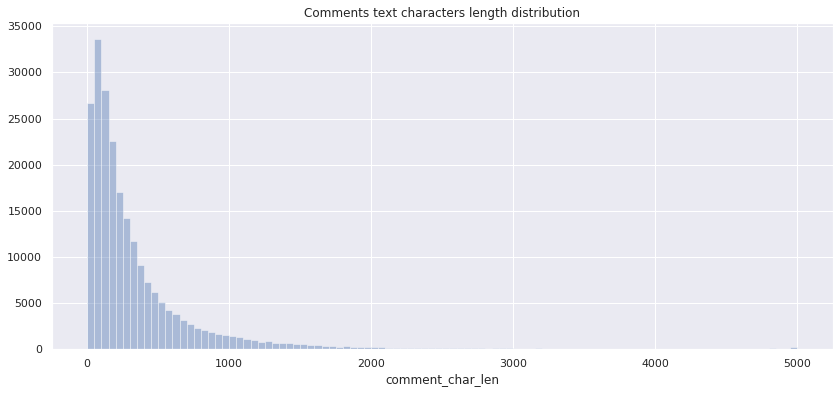

In [29]:
plt.figure(figsize=(14,6));
sns.distplot(train_wiki['comment_char_len'], bins=100, kde=False);
plt.title('Comments text characters length distribution');

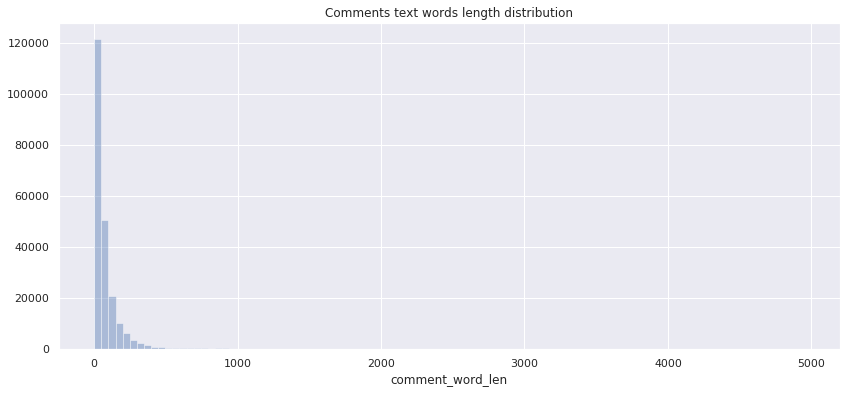

In [30]:
plt.figure(figsize=(14,6));
sns.distplot(train_wiki['comment_word_len'], bins=100, kde=False);
plt.title('Comments text words length distribution');

In [31]:
train_wiki.loc[train_wiki['comment_word_len'] > 1000, 'comment_text'].sample(3)

162869    "  \n \n  WebMySpacePeopleMusicMusic VideosBlo...
135857    why don't you suck my ass until your lips blee...
32055     "I've included a passage of the bible on my us...
Name: comment_text, dtype: object

In [37]:
train_wiki['comment_word_len'].sample(5)

44565      14
180670     29
180835     58
20677      44
58479     691
Name: comment_word_len, dtype: int64

In [43]:
bins = [0,64,128,192,256,384,512,768,1024,2048,4096]
word_len_groups = train_wiki['comment_word_len'].groupby(pd.cut(train_wiki.comment_word_len, bins))
word_lens = pd.DataFrame({'counts': word_len_groups.size(), 
                          'ratio': word_len_groups.size()/train_wiki.shape[0]})
word_lens['cum_ratio'] = word_lens['ratio'].cumsum()
word_lens

,counts,ratio,cum_ratio
comment_word_len,,,
"(0, 64]",141767,0.634165,0.634165
"(64, 128]",44535,0.199218,0.833383
"(128, 192]",16198,0.072458,0.905842
"(192, 256]",8020,0.035876,0.941717
"(256, 384]",6573,0.029403,0.971120
"(384, 512]",2436,0.010897,0.982017
"(512, 768]",2142,0.009582,0.991599
"(768, 1024]",1597,0.007144,0.998743
"(1024, 2048]",268,0.001199,0.999942


In [32]:
bins_wiki = pd.cut(train_wiki['comment_word_len'], bins=20)
bins_wiki

0         (-3.95, 248.5]
1         (-3.95, 248.5]
2         (-3.95, 248.5]
3         (-3.95, 248.5]
4         (-3.95, 248.5]
               ...      
223544    (-3.95, 248.5]
223545    (-3.95, 248.5]
223546    (-3.95, 248.5]
223547    (-3.95, 248.5]
223548    (-3.95, 248.5]
Name: comment_word_len, Length: 223549, dtype: category
Categories (20, interval[float64]): [(-3.95, 248.5] < (248.5, 496.0] < (496.0, 743.5] < (743.5, 991.0] ... (3961.0, 4208.5] < (4208.5, 4456.0] < (4456.0, 4703.5] < (4703.5, 4951.0]]

In [ ]:
bins_wiki

In [20]:
# train_wiki.loc[train_wiki['comment_word_len'] > 1000, 'comment_text'].iloc[2]

In [21]:
# train_wiki.loc[train_wiki['comment_word_len'] > 1000, 'comment_text'].loc[223078]

### Validation and test datasets

In [13]:
test = pd.read_csv('../data/test.csv')
val = pd.read_csv('../data/validation.csv')

In [19]:
print('Val shape:', val.shape)
val.head(3)

Val shape: (8000, 4)


,id,comment_text,lang,toxic
0,0,Este usuario ni siquiera llega al rango de ...,es,0
1,1,Il testo di questa voce pare esser scopiazzato...,it,0
2,2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1


In [21]:
val['lang'].value_counts()

tr    3000
es    2500
it    2500
Name: lang, dtype: int64

In [23]:
print('Test shape:', test.shape)
print('Test columns:', test.columns.values)
test.head(3)

Test shape: (63812, 3)
Test columns: ['id' 'content' 'lang']


,id,content,lang
0,0,Doctor Who adlı viki başlığına 12. doctor olar...,tr
1,1,"Вполне возможно, но я пока не вижу необходимо...",ru
2,2,"Quindi tu sei uno di quelli conservativi , ...",it


In [15]:
test['lang'].value_counts()

tr    14000
pt    11012
ru    10948
fr    10920
it     8494
es     8438
Name: lang, dtype: int64

## Train linear model

In [22]:
text_vect = TfidfVectorizer(
    dtype=np.float32,
#     analyzer="word", 
    ngram_range=(1, 2), 
    max_df=0.9, 
    min_df=3,
#     max_features=200000,
)
# text_vect.fit(data["text"])

In [23]:
params_lr = {
    "C": 5,
    "solver": "lbfgs",
    "max_iter": 200,
#     "multi_class": "ovr",
    "n_jobs": -1,
    "random_state": 42,
}

lr = LogisticRegression(**params_lr)

In [24]:
%%time
pipe_lr = make_pipeline(text_vect, lr)

pipe_lr.fit(train_wiki['comment_text'], train_wiki['toxic']);
pipe_lr.score(val_df['comment_text'], val_df['toxic'])

/home/nj/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/nj/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


CPU times: user 1min 24s, sys: 1min 55s, total: 3min 20s
Wall time: 54.1 s


0.848125

In [25]:
val_df['pred_prob'] = pipe_lr.predict_proba(val_df['comment_text'])[:,1]
val_df['pred'] = pipe_lr.predict(val_df['comment_text'])

Let's take a look at probability of predictions. Seems classifier has pretty low confidence for both 'toxic' and 'non-toxic' classes.

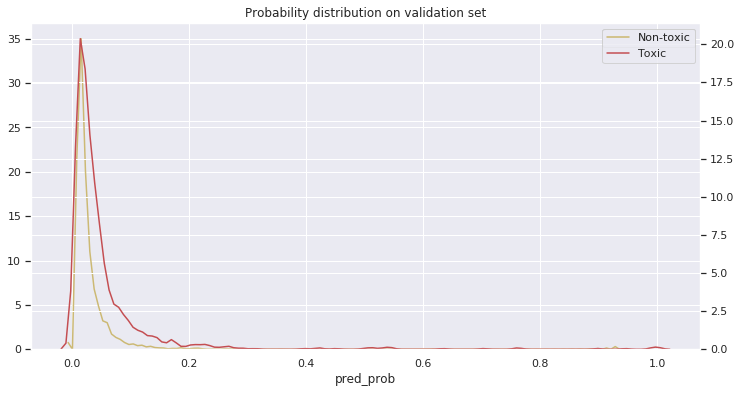

In [26]:
plot_hist = False
fig, ax1 = plt.subplots(figsize=(12,6))
hist1 = sns.distplot(val_df.loc[val_df['toxic'] == 0, 'pred_prob'], color='y', bins=100,
                     hist_kws={"alpha": 0.7}, label='Non-toxic', hist=plot_hist, ax=ax1);
ax2 = ax1.twinx();
hist2 = sns.distplot(val_df.loc[val_df['toxic'] == 1, 'pred_prob'], color='r', bins=100,
                     hist_kws={"alpha": 0.7}, label='Toxic', hist=plot_hist, ax=ax2);
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
plt.title('Probability distribution on validation set');

In [27]:
val_df.head()

,id,comment_text,lang,toxic,pred_prob,pred
0,0,Este usuario ni siquiera llega al rango de ...,es,0,0.029436,0
1,1,Il testo di questa voce pare esser scopiazzato...,it,0,0.013044,0
2,2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1,0.082156,0
3,3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0,0.007296,0
4,4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0,0.007128,0


Let's put all the numbers into one place, split by languages. Column "all" contains both toxic and non-toxic samples, while column "toxic" only positive. Column "pred_toxic" contains only samples _predicted_ positive by classifier (somewhat one-sided confusion matrix by language).  
There is no English language in _validation_ dataset at all. Unfortunately, neither of training datasets have language column therefore we can't compare with training data by language distribution (or absense of any).

In [28]:
val_langs = pd.DataFrame(
                {'all': val_df['lang'].value_counts(),
                 'toxic': val_df.loc[val_df['toxic']==1, 'lang'].value_counts(),
                 'pred_toxic': val_df.loc[val_df['pred']==1, 'lang'].value_counts()})
val_langs

,all,toxic,pred_toxic
es,2500,422,5
it,2500,488,4
tr,3000,320,10


In [29]:
docs = val_df[(val_df['toxic'] == 1)&(val_df['pred'] == 0)]
docs.shape

(1213, 6)

In [30]:
samples = docs.sample(5)

In [31]:
# !pip install eli5

In [32]:
docs['comment_text'].iat[0]

'Vale. Sólo expongo mi pasado. Todo tiempo pasado fue mejor, ni mucho menos, yo no quisiera retroceder 31 años a nivel particular. Las volveria a pasar putas.Fernando '

In [33]:
import eli5
from eli5.lime import TextExplainer

In [34]:
te = TextExplainer(random_state=42)
te.fit(docs['comment_text'].iat[0], pipe_lr.predict_proba)
te.show_prediction()

In [35]:
# KL devirgence low and score is high which means we can trust above explanation
te.metrics_

{'mean_KL_divergence': 0.012154105779051249, 'score': 1.0}

In [36]:
# lgb_params = {
#     "objective": "multiclass",
#     "n_estimators": 1000,
#     "class_weight": {0:2, 1:1, 2:4}, #"balanced",
#     "feature_fraction": 0.8,
#     "bagging_fraction": 0.9,
#     "bagging_freq": 20,
#     "reg_alpha": 0.03, 
#     "reg_lambda": 0.03,
#     "random_state": 42,
#     }

# lgb = LGBMClassifier(**lgb_params)

In [46]:
train_cc[train_cc.id == 2085507]

/home/nj/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,id,comment_text,toxic,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
